# Portfolio Management with Quantum Annealers (Step-by-step)

This single notebook will contain **all phases** in one place:
1. **Phase 1**: data + instance generation
2. Phase 2: QUBO builder + sanity checks
3. Phase 3: classical baselines (Exact/SA), and optionally QAOA
4. Phase 4: (optional) quantum annealer / hybrid solver runs
5. Phase 5: analysis + plots + report tables

**Goal:** choose a subset of assets (binary vector $z\in\{0,1\}^n$) of fixed size $B$ and minimize a penalized Markowitz objective.


## Phase 1 — Data & Instances

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from typing import Optional, Dict, Any, Tuple

# Reproducibility
RNG = np.random.default_rng(123)

def set_seed(seed: int = 0) -> None:
    global RNG
    RNG = np.random.default_rng(seed)

#print("Ready. NumPy:", np.__version__, "Pandas:", pd.__version__)


### 1.1 Configuration (instance grid)

We'll generate instances over a grid like:
- number of assets $n$
- budget $B$ (exactly how many assets to pick)
- risk-return tradeoff $q\in[0,1]$

We will start with **synthetic instances** (fast, controlled) and include a hook to load **real-ish** data from a CSV later.


In [ ]:
# --- Phase 1 config ---
CONFIG = {
    "n_list": [8, 12, 16, 20],      # start small; we'll scale later
    "B_rule": "half",               # "half" or "quarter" or an integer
    "q_list": [0.2, 0.5, 0.8],
    "instance_kind": "synthetic_factor",  # synthetic_factor | synthetic_wishart | from_csv
}

# Function to choose B based on rule
def choose_B(n: int, rule="half") -> int:
    if isinstance(rule, int):
        if not (0 <= rule <= n):
            raise ValueError("B must satisfy 0 <= B <= n")
        return rule
    rule = str(rule).lower()
    if rule == "half":
        return n // 2
    if rule == "quarter":
        return max(1, n // 4)
    raise ValueError(f"Unknown B_rule: {rule}")

# Build a list of instance specs we will loop over later
INSTANCE_SPECS = []
for n in CONFIG["n_list"]:
    B = choose_B(n, CONFIG["B_rule"])
    for q in CONFIG["q_list"]:
        INSTANCE_SPECS.append({"n": n, "B": B, "q": float(q)})

pd.DataFrame(INSTANCE_SPECS)


### 1.2 Synthetic instance generators

We need:
- expected returns $\mu\in\mathbb{R}^n$
- covariance $\Sigma\in\mathbb{R}^{n\times n}$, PSD by construction

We implement two generators:
1) **Factor-model covariance** (controls correlation structure; PSD)
2) **Wishart covariance** (random PSD covariance)


In [3]:
def _ensure_symmetric_psd(Sigma: np.ndarray, jitter: float = 1e-9) -> np.ndarray:
    """Numerically symmetrize and add small jitter to diagonal."""
    Sigma = 0.5 * (Sigma + Sigma.T)
    Sigma = Sigma + jitter * np.eye(Sigma.shape[0])
    return Sigma

def make_instance_synthetic_factor(
    n: int,
    k_factors: int = 3,
    mu_scale: float = 0.02,
    idio_scale: float = 0.10,
    factor_scale: float = 0.20,
    seed: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Factor model:
      r = mu + L f + eps
    where f ~ N(0, I), eps ~ N(0, D)
    => Cov = L L^T + D  (PSD)
    """
    rng = np.random.default_rng(seed) if seed is not None else RNG
    k = min(k_factors, n)

    mu = rng.normal(loc=0.0, scale=mu_scale, size=n)
    L = rng.normal(loc=0.0, scale=factor_scale, size=(n, k))

    # idiosyncratic variances (positive)
    d = rng.lognormal(mean=np.log(idio_scale**2 + 1e-12), sigma=0.5, size=n)
    D = np.diag(d)

    Sigma = L @ L.T + D
    Sigma = _ensure_symmetric_psd(Sigma)
    return mu, Sigma

def make_instance_synthetic_wishart(
    n: int,
    df: Optional[int] = None,
    mu_scale: float = 0.02,
    cov_scale: float = 0.10,
    seed: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Wishart-like PSD covariance:
      Sigma = (X X^T)/df  with X random
    """
    rng = np.random.default_rng(seed) if seed is not None else RNG
    if df is None:
        df = 2 * n

    mu = rng.normal(loc=0.0, scale=mu_scale, size=n)
    X = rng.normal(loc=0.0, scale=cov_scale, size=(n, df))
    Sigma = (X @ X.T) / float(df)
    Sigma = _ensure_symmetric_psd(Sigma)
    return mu, Sigma


### 1.3 Loading “real-ish” instances from CSV

If you provide a CSV of historical prices (columns = tickers, rows = dates), we:
1) compute log returns,
2) estimate $\mu$ as mean return,
3) estimate $\Sigma$ as covariance of returns.


In [4]:
def make_instance_from_price_csv(
    csv_path: str,
    n_max: Optional[int] = None,
    annualize: bool = False,
    trading_days: int = 252,
) -> Tuple[np.ndarray, np.ndarray, list]:
    """
    CSV format assumption:
      - rows: dates (or sequential)
      - columns: asset prices (tickers)
    Returns:
      mu (mean log returns), Sigma (cov of log returns), tickers
    """
    df = pd.read_csv(csv_path)
    if df.columns[0].lower() in {"date", "time", "datetime"}:
        df = df.set_index(df.columns[0])

    if n_max is not None:
        df = df.iloc[:, :n_max]

    tickers = list(df.columns)

    prices = df.astype(float)
    rets = np.log(prices).diff().dropna()

    mu = rets.mean(axis=0).to_numpy()
    Sigma = rets.cov().to_numpy()

    if annualize:
        mu = mu * trading_days
        Sigma = Sigma * trading_days

    Sigma = _ensure_symmetric_psd(Sigma)
    return mu, Sigma, tickers


### 1.4 One unified `make_instance(...)`

This is what we’ll call throughout the notebook.


In [5]:
def make_instance(
    n: int,
    kind: str = "synthetic_factor",
    seed: int = 0,
    csv_path: Optional[str] = None,
) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
    """
    Return (mu, Sigma, meta) where meta includes tickers (if any).
    """
    kind = kind.lower()

    if kind in {"synthetic_factor", "factor"}:
        mu, Sigma = make_instance_synthetic_factor(n=n, seed=seed)
        meta = {"kind": "synthetic_factor", "tickers": [f"A{i}" for i in range(n)]}
        return mu, Sigma, meta

    if kind in {"synthetic_wishart", "wishart"}:
        mu, Sigma = make_instance_synthetic_wishart(n=n, seed=seed)
        meta = {"kind": "synthetic_wishart", "tickers": [f"A{i}" for i in range(n)]}
        return mu, Sigma, meta

    if kind in {"from_csv", "csv"}:
        if not csv_path:
            raise ValueError("csv_path is required when kind='from_csv'")
        mu, Sigma, tickers = make_instance_from_price_csv(csv_path=csv_path, n_max=n)
        meta = {"kind": "from_csv", "tickers": tickers}
        return mu, Sigma, meta

    raise ValueError(f"Unknown instance kind: {kind}")


### 1.5 Quick visualization / sanity check

We’ll plot:
- $\mu$
- covariance heatmap
- eigenvalues (should be nonnegative, up to tiny numerical jitter)


Meta: {'kind': 'synthetic_factor', 'tickers': ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7']}
mu shape: (8,) Sigma shape: (8, 8) min eig: 0.008025006501791934


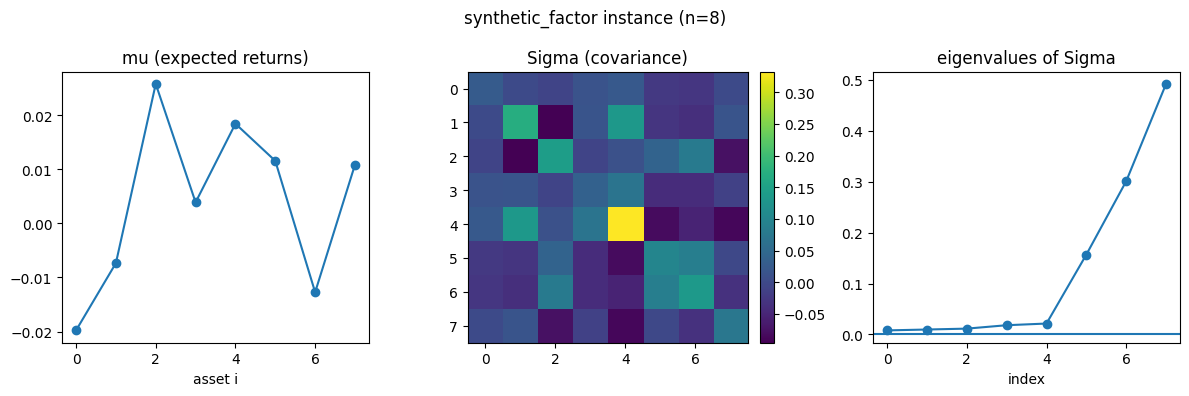

In [6]:
def visualize_instance(mu: np.ndarray, Sigma: np.ndarray, title: str = "") -> None:
    mu = np.asarray(mu).reshape(-1)
    Sigma = np.asarray(Sigma)
    evals = np.linalg.eigvalsh(Sigma)

    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(mu, marker="o")
    ax1.set_title("mu (expected returns)")
    ax1.set_xlabel("asset i")

    ax2 = fig.add_subplot(1, 3, 2)
    im = ax2.imshow(Sigma, aspect="auto")
    ax2.set_title("Sigma (covariance)")
    fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(evals, marker="o")
    ax3.axhline(0.0)
    ax3.set_title("eigenvalues of Sigma")
    ax3.set_xlabel("index")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Demo on one instance
spec = INSTANCE_SPECS[0]
mu, Sigma, meta = make_instance(n=spec["n"], kind=CONFIG["instance_kind"], seed=123)
print("Meta:", meta)
print("mu shape:", mu.shape, "Sigma shape:", Sigma.shape, "min eig:", float(np.min(np.linalg.eigvalsh(Sigma))))
visualize_instance(mu, Sigma, title=f'{meta["kind"]} instance (n={spec["n"]})')


### 1.6 Build an instance registry

This dictionary will be used in later phases (QUBO construction, solvers, plotting).


In [7]:
def build_instance_registry(
    specs,
    kind: str,
    base_seed: int = 0,
    csv_path: Optional[str] = None,
) -> Dict[tuple, Dict[str, Any]]:
    registry: Dict[tuple, Dict[str, Any]] = {}
    for idx, s in enumerate(specs):
        n = int(s["n"])
        B = int(s["B"])
        q = float(s["q"])
        mu, Sigma, meta = make_instance(n=n, kind=kind, seed=base_seed + idx, csv_path=csv_path)
        key = (n, B, q, meta["kind"], base_seed + idx)
        registry[key] = {
            "mu": mu,
            "Sigma": Sigma,
            "meta": meta,
            "n": n,
            "B": B,
            "q": q,
            "seed": base_seed + idx,
        }
    return registry

INSTANCE_REGISTRY = build_instance_registry(INSTANCE_SPECS, kind=CONFIG["instance_kind"], base_seed=2025)
print("Num instances:", len(INSTANCE_REGISTRY))
list(INSTANCE_REGISTRY.keys())[:3]


Num instances: 12


[(8, 4, 0.2, 'synthetic_factor', 2025),
 (8, 4, 0.5, 'synthetic_factor', 2026),
 (8, 4, 0.8, 'synthetic_factor', 2027)]

✅ **Phase 1 done.**  
Next: **Phase 2** (QUBO builder + brute-force sanity checks) in the same notebook.


In [8]:
with open("phase1_instances.pkl", "wb") as f:
    pickle.dump(
        {"CONFIG": CONFIG, "INSTANCE_SPECS": INSTANCE_SPECS, "INSTANCE_REGISTRY": INSTANCE_REGISTRY},
        f
    )
print("Saved phase1_instances.pkl")

Saved phase1_instances.pkl
